# Mourning tweets

In [607]:
import emoji
import pandas as pd
import numpy as np
import glob
import os
import re
import nltk
import pickle
import spacy
import matplotlib.pyplot as plt
from sklearn import set_config
set_config(print_changed_only=False)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [608]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# Lectura de datos

In [609]:
def lectura_tweets(file_path):
    """
    Carga el csv que contiene los tweets.
    :param file_path: path de el arhcivo
    :return: dos dataframes, el primero son los tweets en español, 
    y el segundo los de ingles.
    """
    tweets = pd\
        .read_csv(file_path, sep =',')\
        .reset_index()
    tweets_es = tweets.loc[tweets['lang']=='es']
    tweets_en = tweets.loc[tweets['lang']=='en']
    return [tweets_es, tweets_en]

In [610]:
tweets_es, tweets_en = lectura_tweets(os.path.join('datasets', 'fnmourning.csv'))

# Construccion del lexicon de luto

## Tokenizacion

In [611]:
def limpiar_emoticones(x):
    """
    En el string que entra por parametro, se aisla el emoticon contenido en este, y se
    retorna este valor. Si no encuentra emoticon retorna el mismo input string
    :param x: input string
    :return: string de la descripcion del emoticon 
    """
    res = x
    try: 
        res = re.search('(:(.*?):)',x).group(0)
    except:
        pass
    return res
def limpiar_docs(doc):
    """
    Se limpia el string del documento de simbolos y algunos signos de puntuacion.
    Esta funcion es necesaria para no deshacerse de los emoticones, sino de simbolos
    especificos.
    :param doc: input string
    :return: string del documento limpio 
    """
    doc_limpio = \
        ' '.join(doc
                 .lower()
                 .replace('@',' ')
                 .replace('#', ' ')
                 .replace('%', ' ')
                 .replace('&', ' ')
                 .replace("'", ' ')
                 .replace("*", ' ')
                 .replace("$", ' ')
                 .replace("+", ' ')
                 .replace("-", ' ')
                 .replace(":", ' ')
                 .replace("~", ' ')
                 .replace("|", ' ')
                 .replace("{", ' ')
                 .replace("}", ' ')
                 .replace("(", ' ')
                 .replace(")", ' ')
                 .replace("!", ' ')
                 .replace("¡", ' ')
                 .split())
    doc_limpio = emoji.emojize(str(emoji.demojize(doc_limpio).encode("unicode_escape"))[2:-1])
    doc_limpio = doc_limpio
    return doc_limpio
def tokenizacion_spanish_documento_nltk(doc):
    """
    Se tokeniza el string del documento en el idioma español usando el paquete nltk. 
    Se usa stemming, se quitan stop words y se normaliza la palabra covid-19
    :param doc: input string
    :return: lista de los tokens del documento 
    """
    nltk_stop_words_es = set(nltk.corpus.stopwords.words("spanish"))
    stemmer_es = nltk.stem.SnowballStemmer("spanish")
    doc_limpio = limpiar_docs(doc)
    doc_p = nltk.word_tokenize(doc_limpio)
    doc_process = [emoji.demojize(stemmer_es.stem(word.strip()))
                   if 'covid' not in word else 'covid-19'
                   for word in doc_p 
                   if word not in nltk_stop_words_es
                   and ('https' not in word)
                   and ('\n' not in word)
                   and ('/' not in word)
                   and ('\\' not in word)
                   and ('y' != word)
                   and ('a' != word)
                   and ('o' != word)
                   and (':' not in word)
                   and (',' not in word)
                   and ('.' not in word)
                   and (';' not in word)
                   and ('``' not in word)
                   and ('(' not in word)
                   and (')' not in word)
                   and ('"' not in word)
                   and ("''" not in word)
                   and not( (any(char.isdigit() for char in word)) and ('covid' not in word))
                  ]
    doc_process_sin_emoticones = [word for word in doc_process if ':' not in word]
    doc_process_emoticones = [limpiar_emoticones(word) for word in doc_process if ':' in word]
    doc_process_limpio = doc_process_sin_emoticones + doc_process_emoticones
    return np.unique(doc_process_limpio)
def tokenizacion_english_documento_nltk(doc):
    """
    Se tokeniza el string del documento en el idioma ingles usando el paquete nltk. 
    Se usa stemming, se quitan stop words y se normaliza la palabra covid-19
    :param doc: input string
    :return: lista de los tokens del documento 
    """
    nltk_stop_words_en = set(nltk.corpus.stopwords.words("english"))
    stemmer_en = nltk.stem.porter.PorterStemmer()
    doc_limpio = limpiar_docs(doc)
    doc_p = nltk.word_tokenize(doc_limpio)
    doc_process = [emoji.demojize(stemmer_en.stem(word.strip()))
                   if 'covid' not in word else 'covid-19'
                   for word in doc_p 
                   if word not in nltk_stop_words_en
                   and ('https' not in word)
                   and ('\n' not in word)
                   and ('/' not in word)
                   and ('\\' not in word)
                   and (':' not in word)
                   and (',' not in word)
                   and ('.' not in word)
                   and (';' not in word)
                   and ('``' not in word)
                   and ('(' not in word)
                   and (')' not in word)
                   and ('"' not in word)
                   and ("''" not in word)
                   and not( (any(char.isdigit() for char in word)) and ('covid' not in word))
                  ]
    doc_process_sin_emoticones = [word for word in doc_process if ':' not in word]
    doc_process_emoticones = [limpiar_emoticones(word) for word in doc_process if ':' in word]
    doc_process_limpio = doc_process_sin_emoticones + doc_process_emoticones
    return np.unique(doc_process_limpio)

def tokenizacion_spanish(tweets_df):
    """
    Se tokeniza los documentos del dataframe de tweets en español que entra por parametro
    :param tweets_df: dataframe de tweets en español
    :return: dataframe de tweets tokenizados 
    """
    res = tweets_df.copy()
    res['tokens'] = res['text'].apply(tokenizacion_spanish_documento_nltk)
    res  = res.explode('tokens', ignore_index = True).dropna()
    return res
def tokenizacion_english(tweets_df):
    """
    Se tokeniza los documentos del dataframe de tweets en ingles que entra por parametro
    :param tweets_df: dataframe de tweets en ingles
    :return: dataframe de tweets tokenizados 
    """
    res = tweets_df.copy()
    res['tokens'] = res['text'].apply(tokenizacion_english_documento_nltk)
    res  = res.explode('tokens', ignore_index = True).dropna()
    return res

In [612]:
tweets_es_tokenizado = tokenizacion_spanish(tweets_es)

In [613]:
tweets_en_tokenizado = tokenizacion_english(tweets_en)

## Probabilidad escalada

In [614]:
def scaled_likelihood(tweets_tokenizado):
    """
    Se calcula una estimacion de la probabilidad de que cada token aparezca en tweets
    mourning o no mourning
    :param tweets_tokenizado: dataframe de tweets tokenizados
    :return: dataframe de tokens con sus probabilidades 
    """
    total = tweets_tokenizado\
        .groupby('tag')\
        .agg(total_apariciones = ('index', 'nunique'))\
        .reset_index()
    total_por_categoria = tweets_tokenizado\
        .groupby(['tokens', 'tag'])\
        .agg(total_apariciones_categoria = ('index', 'count'))\
        .reset_index()
    res = total_por_categoria.merge(total, on = 'tag', how = 'left')
    res['scaled_likelihood'] = res['total_apariciones_categoria']/res['total_apariciones']
    return res.drop('total_apariciones', axis = 1)

In [615]:
sl_es_tweets = scaled_likelihood(tweets_es_tokenizado)
sl_en_tweets = scaled_likelihood(tweets_en_tokenizado)

## Word/emoticons que mejor describen luto

In [616]:
def visualizacion_n_palabras_mas_likely_mourning(sl_tweets,n, idioma):
    """
    Visualizar la n palabras con mas probabilidad de aparecer en un tweet de mourning
    :param sl_tweets: dataframe de tokens con sus probabilidades estimadas
    :param n: numero de tokens a visualizar
    :param idioma: idioma de los tokens
    :return:  
    """
    sl_es_tweets\
        .loc[sl_es_tweets['tag']=='mourning']\
        .sort_values('scaled_likelihood', ascending = False)\
        [:n]\
        .plot.bar(x = 'tokens',
                  y = 'scaled_likelihood',
                  title = f'Las {n} palabras en {idioma} que mejor describen el luto')
    plt.show()
def visualizacion_n_emojis_mas_likely_mourning(sl_tweets,n, idioma):
    """
    Visualizar los n emoticones con mas probabilidad de aparecer en un tweet de mourning
    :param sl_tweets: dataframe de tokens con sus probabilidades estimadas
    :param n: numero de emoticones a visualizar
    :param idioma: idioma donde aparecieron los emoticones
    :return:  
    """
    sl_tweets['emoticon'] = sl_tweets['tokens'].str.contains(':').astype(int)
    emojis = sl_tweets\
        .loc[(sl_tweets['tag']=='mourning')&(sl_tweets['emoticon']==1)]\
        .sort_values('scaled_likelihood', ascending = False)\
        [:20]
    emojis.plot.bar(x = 'tokens', 
                    y = 'scaled_likelihood',
                    title = f'Los {n} emojis en {idioma} que mejor describen el luto')
    plt.show()
    emojis['imagen'] = emojis['tokens'].apply(emoji.emojize)
    print(f'Tabla de los {n} emojis en {idioma} que mejor describen el luto')
    display(emojis[['imagen', 'scaled_likelihood']])

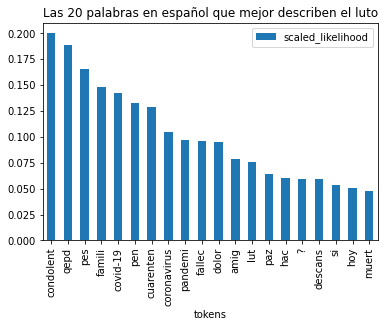

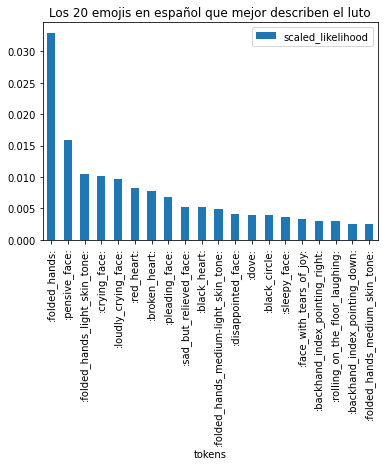

Tabla de los 20 emojis en español que mejor describen el luto


,imagen,scaled_likelihood
262,🙏,0.032964
452,😔,0.015848
265,🙏🏻,0.010460
177,😢,0.010143
356,😭,0.009667
515,❤,0.008241
121,💔,0.007765
475,🥺,0.006815
539,😥,0.005230
104,🖤,0.005230


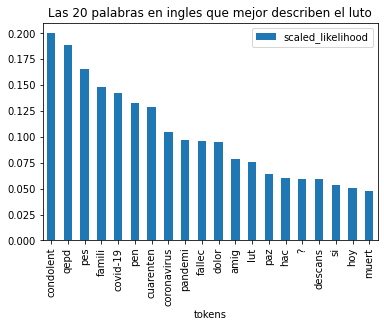

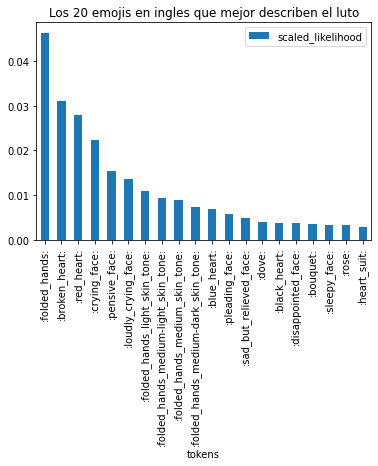

Tabla de los 20 emojis en ingles que mejor describen el luto


,imagen,scaled_likelihood
212,🙏,0.046317
94,💔,0.031131
398,❤,0.027904
144,😢,0.022399
351,😔,0.015376
287,😭,0.013667
216,🙏🏻,0.010820
220,🙏🏼,0.009301
222,🙏🏽,0.008922
218,🙏🏾,0.007403


In [617]:
visualizacion_n_palabras_mas_likely_mourning(sl_es_tweets, 20, 'español')
visualizacion_n_emojis_mas_likely_mourning(sl_es_tweets, 20, 'español')
visualizacion_n_palabras_mas_likely_mourning(sl_en_tweets, 20, 'ingles')
visualizacion_n_emojis_mas_likely_mourning(sl_en_tweets, 20, 'ingles')

## Score propuesto

In [618]:
def lista_score(tweets_tokenizado, n , idioma):
    """
    generar lista de los primeros n tokens con mayor score, a partir de los tweets 
    tokenizados. El score se definió como la diferencia entre la probabilidad de aparecer
    en un tweet de mourning menos la de aparecer en un tweet de no mourning
    :param tweets_tokenizado: dataframe de los tweets tokenizados
    :param n: numero de tokens a visualizar
    :param idioma: idioma donde aparecieron los emoticones
    :return: lista de los n tokens con mayor score  
    """
    tweets_tokenizado_slikelihood = scaled_likelihood(tweets_tokenizado)
    res = tweets_tokenizado_slikelihood\
        .drop('total_apariciones_categoria', axis = 1)\
        .set_index(['tokens', 'tag'])\
        .unstack(fill_value=0)
    res.columns = res.columns.droplevel()
    res = res.reset_index()
    res['score'] = (res['mourning']-res['no mourning'])
    res = res.sort_values(by='score', ascending = False)
    res.head(20).plot.bar(x = 'tokens', 
                          y = 'score', 
                          title = f'Los {n} tokens en {idioma} con mayor score')
    return res

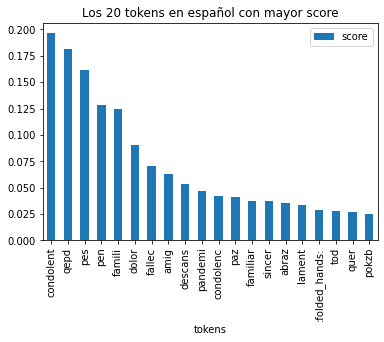

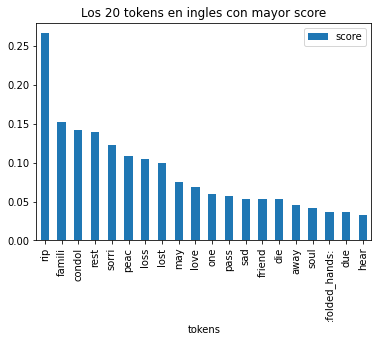

In [619]:
score_es_tweets = lista_score(tweets_es_tokenizado,20,'español')
score_en_tweets = lista_score(tweets_en_tokenizado,20,'ingles')

# Clasificadores para detectar luto

## Creacion de Features

In [620]:
def feature_representation(tweets_tokenizado, n_apariciones):
    """
    Creación de features a partir de los tweets tokenizados. Esta construccion se hizo
    con el term frecuency de cada token. La clase POSITIVA se definió como las clase de
    MOURNING. Se da la opcion de quitar aquellos tokens que tienen menos de n_apariciones.
    :param tweets_tokenizado: dataframe de los tweets tokenizados
    :param n_apariciones: numero de apariciones para filtrar los tokens
    :return: dataframe con los tf de cada token como features de los tweets 
    """
    # filtrar aquellos tokens que aparecen muy poco
    total = tweets_tokenizado\
        .groupby('tokens')\
        .agg(total_apariciones = ('index', 'count'))\
        .reset_index()
    tokens_finales = total.loc[total['total_apariciones']>=n_apariciones, 'tokens'].unique()
    
    # generacion features
    tweets_tokenizado = tweets_tokenizado\
        [tweets_tokenizado['tokens'].isin(tokens_finales)]
    tweets_tokenizado['tag'] = (tweets_tokenizado['tag']=='mourning').astype(int)
    tweets_tokenizado['indicadora'] = 1
    tweets_tokenizado_filtrado = tweets_tokenizado[['index','tag','tokens', 'indicadora']]\
        .copy()
    tweets_features = tweets_tokenizado_filtrado\
        .set_index(['index','tag','tokens'])\
        .unstack(fill_value = 0)
    tweets_features.columns = tweets_features.columns.droplevel()
    tweets_features = tweets_features.reset_index()

    return tweets_features

In [621]:
fr_es_tweets = feature_representation(tweets_es_tokenizado, 10)
fr_en_tweets = feature_representation(tweets_en_tokenizado, 10)

/home/yacirramirez/anaconda3/envs/nlp3_7/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yacirramirez/anaconda3/envs/nlp3_7/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yacirramirez/anaconda3/envs/nlp3_7/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

## Division train test

In [622]:
def train_test_particion(features_base ):
    """
    Particion en train y test de la base de features, 66-33 porciento.
    :param features_base: dataframe de los features
    :return: 4 dataframes 
    """
    X_train, X_test, y_train, y_test = \
        train_test_split(features_base.drop(['tag', 'index'], axis =1),
                         features_base['tag'], 
                         test_size=0.33,
                         random_state=42)
    return X_train, X_test, y_train, y_test

In [623]:
X_train_en, X_test_en, y_train_en, y_test_en = train_test_particion(fr_en_tweets)
X_train_es, X_test_es, y_train_es, y_test_es = train_test_particion(fr_es_tweets)


## Entrenamiento y metricas de los clasificadores

In [624]:
def entrenar_modelos(X_train,y_train, con_emoticones = True):
    """
    Entrenamiento de los modelos naive bayes, regresion logistica, decision tree y
    random forest
    :param X_train: dataframe de entrenamiento
    :param y_train: dataframe de la variable a predecir
    :param con_emoticones: booleano para indicar si se dejan los features de emoticones o no.
    :return: diccionario con los 4 modelos entrenados 
    """
    X, y = X_train.copy(), y_train.copy()
    if not con_emoticones:
        cols_sin_emojis = [col for col in X_train.columns if ':' not in col]
        X, y = X_train[cols_sin_emojis].copy(), y_train.copy()
    else:
        pass
        
    nb_clf = MultinomialNB()
    nb_clf.fit(X, y)
    
    lr_clf = LogisticRegression(random_state=0)
    lr_clf.fit(X, y)
    
    tree_clf = tree.DecisionTreeClassifier()
    tree_clf = tree_clf.fit(X, y)
    
    rf_clf = RandomForestClassifier(max_depth=2, random_state=0)
    rf_clf.fit(X, y)
    res = {'naive_bayes': nb_clf,
           'logistic_regression': lr_clf,
           'decision_tree':tree_clf, 
           'random_forest':rf_clf}
    return res
def sacar_metricas(clf_entrenado, X_test, y_test, con_emoticones = True):
    """
    Se sacan las metricas de precision, recall y f1-score para la clase positiva. Se da la
    opcion de especificar si es necesario quitar las columnas de los emoticones para generar
    la prediccion.
    :param clf_entrenado: clasificador que ya ha sido entrenado
    :param X_test: dataframe de los features a predecir
    :param y_test: dataframe de los valores reales a comparar con la prediccion
    :param con_emoticones: booleano para indicar si se dejan los features de emoticones o 
    no
    :return: diccionario con las metricas 
    """
    if not con_emoticones:
        cols_sin_emojis = [col for col in X_test.columns if ':' not in col]
        y_pred = clf_entrenado.predict(X_test[cols_sin_emojis])
    else:
        y_pred = clf_entrenado.predict(X_test)
    y_true = y_test
    
    res =  classification_report(y_true,
                                 y_pred,
                                 labels = [0,1],
                                 target_names=['Clase 0', 'Clase 1'])
    print(res)
    res =  classification_report(y_true,
                                 y_pred,
                                 labels = [0,1],
                                 target_names=['Clase 0', 'Clase 1'],
                                 output_dict = True
                                )
    return res
def sacar_metricas_para_cada_modelo(dict_clf, X_test, y_test, con_emoticones = True):
    """
    Se sacan las metricas de precision, recall y f1-score para la clase positiva de cada 
    clasificador en el diccionario.
    :param clf_entrenado: clasificador que ya ha sido entrenado
    :param X_test: dataframe de los features a predecir
    :param y_test: dataframe de los valores reales a comparar con la prediccion
    :param con_emoticones: booleano para indicar si se dejan los features de emoticones o 
    no
    :return: diccionario con las metricas 
    """
    resultados = {}
    for clf_name in dict_clf:
        print()
        print(clf_name)
        print()
        resultados[clf_name] = sacar_metricas(dict_clf[clf_name], X_test, y_test, con_emoticones)
        print()
    return resultados

### Resultados para tweets en español

In [625]:

modelos_con_emojis_es = entrenar_modelos(X_train_es, y_train_es, True)
modelos_sin_emojis_es = entrenar_modelos(X_train_es, y_train_es, False)

print('Resultados CON emojis')
resultados_con_emojis_es = sacar_metricas_para_cada_modelo(modelos_con_emojis_es,X_test_es,y_test_es, True)
print()
print('Resultados SIN emojis')
resultados_sin_emojis_es = sacar_metricas_para_cada_modelo(modelos_sin_emojis_es,X_test_es,y_test_es, False)

Resultados CON emojis

naive_bayes

              precision    recall  f1-score   support

     Clase 0       0.84      0.85      0.85      2175
     Clase 1       0.84      0.83      0.84      2079

    accuracy                           0.84      4254
   macro avg       0.84      0.84      0.84      4254
weighted avg       0.84      0.84      0.84      4254



logistic_regression

              precision    recall  f1-score   support

     Clase 0       0.90      0.94      0.92      2175
     Clase 1       0.93      0.89      0.91      2079

    accuracy                           0.91      4254
   macro avg       0.91      0.91      0.91      4254
weighted avg       0.91      0.91      0.91      4254



decision_tree

              precision    recall  f1-score   support

     Clase 0       0.87      0.89      0.88      2175
     Clase 1       0.88      0.86      0.87      2079

    accuracy                           0.87      4254
   macro avg       0.87      0.87      0.87      425

### Resultados para tweets en inglés

In [ ]:
modelos_con_emojis_en = entrenar_modelos(X_train_en, y_train_en, True)
modelos_sin_emojis_en = entrenar_modelos(X_train_en, y_train_en, False)

print('Resultados CON emojis')
resultados_con_emojis_en = sacar_metricas_para_cada_modelo(modelos_con_emojis_en,X_test_en,y_test_en, True)
print()
print('Resultados SIN emojis')
resultados_sin_emojis_en = sacar_metricas_para_cada_modelo(modelos_sin_emojis_en,X_test_en,y_test_en, False)

### Comparacion de resultados

In [ ]:
def comparacion_metricas_entre_clasificadores(resultados):
    """
    Visualizar los resultados de los clasificadores sobre el test, de forma 
    NB vs LR vs DT vs RF por cada metrica.
    :param resultados: diccionario con las metricas
    :return:
    """
    for key in resultados.keys():
        print(key.upper())
        data = []
        for clf_name in  resultados[key]:
            for metrica in resultados[key][clf_name]['Clase 1']:
                data.append([clf_name, metrica,resultados[key][clf_name]['Clase 1'][metrica]])
        data = pd.DataFrame(data, columns = ['Clasificador', 'metrica', 'valor'])
        for metrica in ['precision', 'recall', 'f1-score']:
            data.loc[data['metrica']==metrica]\
                .plot.bar(x = 'Clasificador', 
                          y = 'valor',
                          title = f'{key}, Clase Mourning (positiva), {metrica}'
                         )
            plt.show()
        
        
def comparacion_metricas_entre_emoji_noEmoji(resultados):
    """
    Visualizar los resultados de los clasificadores sobre el test, de forma 
    con emoticones vs sin emoticones por cada metrica, cada tipo de clasificador y 
    cada idioma.
    :param resultados: diccionario con las metricas
    :return:
    """
    data = []
    for key in resultados.keys():
        for clf_name in  resultados[key]:
            for metrica in resultados[key][clf_name]['Clase 1']:
                data.append([key, clf_name, metrica,resultados[key][clf_name]['Clase 1'][metrica]])
    data = pd.DataFrame(data, columns = ['tipo','Clasificador', 'metrica', 'valor'])
    for metrica in ['precision', 'recall', 'f1-score']:
        for clf_name in data['Clasificador'].unique():
            data.loc[(data['metrica']==metrica)&
                     (data['Clasificador']==clf_name)&
                     (data['tipo'].str.contains('español'))
                    ]\
                .plot.bar(x = 'tipo', 
                          y = 'valor',
                          title = f'Español, {clf_name}, Clase Mourning (positiva), {metrica}'
                         )
            plt.show()
            display(data.loc[(data['metrica']==metrica)&
                     (data['Clasificador']==clf_name)&
                     (data['tipo'].str.contains('español'))
                    ])
            
            data.loc[(data['metrica']==metrica)&
                     (data['Clasificador']==clf_name)&
                     (data['tipo'].str.contains('ingles'))
                    ]\
                .plot.bar(x = 'Clasificador', 
                          y = 'valor',
                          title = f'Ingles, {clf_name}, Clase Mourning (positiva), {metrica}'
                         )
            plt.show()
            display(data.loc[(data['metrica']==metrica)&
                     (data['Clasificador']==clf_name)&
                     (data['tipo'].str.contains('ingles'))
                    ])


In [ ]:
resultados = \
    {'español con emojis':resultados_con_emojis_es,
     'ingles con emojis':resultados_con_emojis_en,
     'español sin emojis':resultados_sin_emojis_es,
     'ingles sin emojis':resultados_sin_emojis_en
    }
comparacion_metricas_entre_clasificadores(resultados)
comparacion_metricas_entre_emoji_noEmoji(resultados)

# Feature Importance

In [ ]:
def sacar_feature_importance_lr(lr_entrenado, X_test, con_emoticones = True):
    """
    Visualizar la feature importance (pesos) de una regresion logistica
    :param lr_entrenado: lr entrenado
    :param X_test: base ejemplo con las features utilizadas
    :param con_emoticones: Boolean para determinar si es necesario quitar los emoticones o 
    no
    :return:
    """
    features = X_test.columns
    if not con_emoticones:
        features = [col for col in X_test.columns if ':' not in col]
    coefs = [coef for coef in lr_entrenado.coef_[0]]
    importance = pd\
        .DataFrame(list(zip(features, coefs)), 
                   columns = ['features', 'importance'])\
        .sort_values(by = 'importance', ascending = False)
    importance[:10].plot.bar(x = 'features',y='importance', title = 'Logistic Regression Biggest 10 coeficients (signed)')
    plt.show()

In [ ]:
def sacar_feature_importance_rf(rf_entrenado, X_test, con_emoticones = True):
    """
    Visualizar la feature importance (MDI) de un random forest
    :param lr_entrenado: lr entrenado
    :param X_test: base ejemplo con las features utilizadas
    :param con_emoticones: Boolean para determinar si es necesario quitar los emoticones o 
    no
    :return:
    """
    features = X_test.columns
    if not con_emoticones:
        features = [col for col in X_test.columns if ':' not in col]
    coefs = [coef for coef in rf_entrenado.feature_importances_]
    importance = pd\
        .DataFrame(list(zip(features, coefs)), 
                   columns = ['features', 'importance'])\
        .sort_values(by = 'importance', ascending = False)
    importance[:10].plot.bar(x = 'features',y='importance', title = 'Random Forest Biggest 10 Impurity Importances')
    plt.show()

## Logistic Regression Importances

In [ ]:
print('ESPAÑOL CON EMOJIS')
sacar_feature_importance_lr(modelos_con_emojis_es['logistic_regression'], X_test_es)

In [ ]:
print('ESPAÑOL SIN EMOJIS')
sacar_feature_importance_lr(modelos_sin_emojis_es['logistic_regression'], X_test_es, False)

In [ ]:
print('INGLES CON EMOJIS')
sacar_feature_importance_lr(modelos_con_emojis_en['logistic_regression'], X_test_en)

In [ ]:
print('INGLES SIN EMOJIS')
sacar_feature_importance_lr(modelos_sin_emojis_en['logistic_regression'], X_test_en, False)

## Random Forest Importances

In [ ]:
print('ESPAÑOL CON EMOJIS')
sacar_feature_importance_rf(modelos_con_emojis_es['random_forest'], X_test_es)

In [ ]:
print('ESPAÑOL SIN EMOJIS')
sacar_feature_importance_rf(modelos_sin_emojis_es['random_forest'], X_test_es, False)

In [ ]:
print('INGLES CON EMOJIS')
sacar_feature_importance_rf(modelos_con_emojis_en['random_forest'], X_test_en)

In [ ]:
print('INGLES SIN EMOJIS')
sacar_feature_importance_rf(modelos_sin_emojis_en['random_forest'], X_test_en, False)